In [848]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d

In [849]:
def create_edge(A, node_pairs, rest_length = 1):
    """
    Function that creates edges between nodes 
    input:
        - A: adjacency matrix
        - node_pairs: np.array with nodes that have an edge 
        - rest_length: rest length of edges, assume that all pairs have the same rest length
    """
    A[node_pairs[:,0],node_pairs[:,1]] = rest_length
    A[node_pairs[:,1],node_pairs[:,0]] = rest_length

#initialize X-matrix with nodes
N = 10
X = np.zeros((3,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(10, size = np.shape(X[:,4:]))

#initialize adjacency matrix
cables = np.zeros((N,N))
edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4], [7, 8], [8,9]])
create_edge(cables, edges, 1)
fixed_points = [0,1,2,3]

In [850]:
def E_cable_elast_net(X, A, L, k ):
    """
    Function that calculates the total energy of a graph network of cables 
    input:
        - X: matrix of nodes and their positions 
        - A: adjency matrix for the graph network 
        - L: matrix including all rest lengths in the graph network 
        - k: material parameter
    output: 
        - energy: potential energy of the graph network 
    """
    energy = 0 
    N = np.shape(A)[0]
    for i in range(N):
        for j in range(i, N):
            l_ij = L[i,j]
            if(A[i,j] and np.linalg.norm(X[:,i] - X[:,j]) > l_ij):
                energy += k/(2*l_ij**2) * (np.linalg.norm(X[:,i] - X[:,j]) - l_ij)**2
    return energy

def E_ext(X, mg):
    """
    Function that computes the potential energy of all external loads in the graph network 
    input:
        - X: matrix of nodes and their positions 
        - mg: weight of the external loads, assumed to be homogeneous 
    """
    return np.sum(X[2] * mg)

def derivative_cable(x_i, x_j, l_ij, k):
    """
    function that computes the derivative of the potential energy of a cable between nodes x_i and x_j with regard to x_i
    input:
        - x_i: first node and the node we compute the derivative of 
        - x_j: the second node in the edge
        - l_ij: resting length of the edge 
        - k: material parameter
    output:
        - derivative of potential enregy of a cable with regard to x_i
    """
    norm = np.linalg.norm(x_i - x_j)
    if(norm > l_ij):
        return k/(l_ij**2) * (norm - l_ij) * (x_i - x_j) /norm 
    else:
        return np.zeros_like(x_i -x_j)

def derivative_external_load(x_i,mg_i):
    """
    function that computes the derivative of potential energy of an external load
    input:
        - x_i: external load node 
        - mg_i: weight of external load
    output:
        - numpy array containing the derivative 
    """
    return np.array([0,0,mg_i])


In [851]:
def E_bar_elast_net(X, B, L, pg, c = 1):
    """
    Function that calculates the total energy of a graph network of bars 
    input:
        - X: matrix of nodes and their positions 
        - B: adjency matrix for the graph network 
        - L: matrix including all rest lengths in the graph network 
        - k: material parameter
    output: 
        - energy: potential energy of the graph network 
    """
    energy = 0 
    N = np.shape(B)[0]
    for i in range(N):
        for j in range(i, N):
            if(B[i,j]):
                l_ij = L[i,j]
                energy += c/(2*l_ij**2)*(np.linalg.norm(X[:,i] - X[:,j], 2) - l_ij)**2 + pg/2 *l_ij * (X[:,i][2] + X[:,j][2])
    return  energy

def derivative_bar(x_i, x_j, l_ij, c = 1):
    """
    function that computes the derivative of the potential energy of a bar between nodes x_i and x_j with regard to x_i
    input:
        - x_i: first node and the node we compute the derivative of 
        - x_j: the second node in the edge
        - l_ij: resting length of the edge 
        - c: material parameter
    output:
        - derivative of potential enregy of a bar with regard to x_i
    """
    norm = np.linalg.norm(x_i - x_j)
    return c/(l_ij**2) * (norm - l_ij) * (x_i - x_j) /norm 

def derivative_bar_grav(x_i, l_ij, pg):
    """
    function that computes the derivative of gravitational potential energy of a bar 
    input:
        - x_i: node in a bar
        _ l_ij, resting length of bar
        - pg: line density of the bar multiplied by gravitational accceleration on the earth's surface
    output:
        - numpy array containing the derivative 
    """
    return np.array([0,0,l_ij*pg/2])

In [852]:
def gradient_E_cable_net(X, A, L, fixed_points, mg,c):
    """
    Function that computes the gradient of potential energy for a cable network
    input: 
        - X: matrix of nodes and their positions 
        - A: adjadjacency matrix 
        - L: matrix with resting lengths
        - mg: eight of external loads 
        - c: material parameter
    outout:
        - gradient_E: gradient of potential energy for a cabel network
    """
    N = np.shape(X)[1]
    gradient_E = np.zeros_like(X)
    for i in range(N):
        if(i in fixed_points):
            continue
        gradient_E[:,i] += derivative_external_load(X[:,i], mg)
        for j in  range(N):
            if(A[i,j]):
                gradient_E[:,i] += derivative_cable(X[:,i], X[:,j], L[i,j],c)
    return gradient_E

In [853]:
def E(X, A, B, L, fixed_points, mg, pg, k, c):
    """
    Function that computes the energy of a network that has cables and bars 
    input:
        - X: matrix of nodes and their positions 
        - A: adjacency matrix for cables
        - B: adjacency matrix for bars
        - L: resting lengths 
        - mg: weight of external nodes 
        - pg: line density of bar multiplied by earths gravitational acceleration on the surface 
        - k: material paramter of cable
        - c: material paramter of bar
    output:
        - Total potential energy of the graph network
    """
    return E_bar_elast_net(X, B, L, pg, c) + E_cable_elast_net(X, A, L, k) + E_ext(X, mg)

def f(X):
    """ 
    constraint function
    input:
        - X: matrix of nodes and their positions 
    output:
        - f(X)
    """
    return (X[0]**2 + X[1]**2)/20.0

def df(X):
    """
    derivatives of constraint function 
    """
    Y = np.zeros_like(X)
    Y[0] = X[0]/10 
    Y[1] = X[1]/10
    Y[2] = np.zeros_like(X[2])
    return Y

def constraint(X):
    """
    function that computes the constraint inequality function on each node in the network 
    input:
        - X: matrix of nodes and their positions 
    output:
        - constraint inequality function 
    """
    return np.maximum(-(X[2] - f(X)), np.zeros_like(X[2]))

def gradient_constraint(X):
    """
    function that computes the gradient of the constraint inequality function 
    input: 
        - X: matrix of nodes and their positions 
    output:
        - gradient of constraint inequality function 
    """
    Y = -df(X)
    Y[2] = np.ones_like(X[-1])
    return Y

def quad_penalty(X, A, B, L, fixed_points, mg, pg, k , c, mu):
    """ 
    function that computes the quadratic penalty function
    input:
        - X: matrix of nodes and their positions 
        - A: adjacency matrix for cables
        - B: adjacency matrix for bars
        - L: resting lengths 
        - mg: weight of external nodes 
        - pg: line density of bar multiplied by earths gravitational acceleration on the surface 
        - k: material paramter of cable
        - c: material paramter of bar
    output:
        - quadratic penalty function
    """

    return E(X, A, B, L, fixed_points, mg, pg, k, c) + mu/2 * np.sum(constraint(X)**2)

def gradient_E(X, A, B, L, fixed_points, mg, pg, k, c):
    """
    Function that computes the gradient of potential energy for a tensegrity structure
    input:
        - X: matrix of nodes and their positions 
        - A: adjacency matrix for cables
        - B: adjacency matrix for bars
        - L: resting lengths 
        - mg: weight of external nodes 
        - pg: line density of bar multiplied by earths gravitational acceleration on the surface 
        - k: material paramter of cable
        - c: material paramter of bar
    output:
        - gradient_E: gradient of potential energy
    """
    N = np.shape(X)[1]
    gradient_E = np.zeros_like(X)
    for i in range(N):
        if(i in fixed_points):
            continue
        gradient_E[:,i] += derivative_external_load(X[:,i], mg)
        for j in  range(N):
            if(A[i,j] == 1):
                gradient_E[:,i] += derivative_cable(X[:,i], X[:,j], L[i,j], k )
            if(B[i,j] == 1):
                gradient_E[:,i] += derivative_bar(X[:,i], X[:,j], L[i,j], c) + derivative_bar_grav(X[:, i],L[i,j], pg)

    return gradient_E

def gradient_quad_penalty(X, A, B, L, fixed_points, mg, pg, k, c, mu):
    """ 
    computes the gradient of the quadrative penalty function for inequality constraints
    input:
        - X: matrix of nodes and their positions 
        - A: adjacency matrix for cables
        - B: adjacency matrix for bars
        - L: resting lengths 
        - mg: weight of external nodes 
        - pg: line density of bar multiplied by earths gravitational acceleration on the surface 
        - k: material paramter of cable
        - c: material paramter of bar
        - mu: quadrative penaltty parameter
    output:
        - gradient of the quadrative penalty function for inequality constraints
    """
    return gradient_E(X, A, B, L, fixed_points, mg, pg, k, c) + mu * gradient_constraint(X)*constraint(X)

In [854]:
def armijo_step(f, gradient_f, X, p_k, *args, alpha_0 = 1, c = 1e-3, rho = 1/2):
    """
    function that computes a steplength for armijo condition 
    input:
        - f: function we optimize
        - gradient_f: gradient of f
        - X: matrix of nodes and their positions
        - p_k: search direction
        - *args: arguments used in f and gradient_f
        - alpha_0: first steplength 
        - c: paramter for computing the armijo condition 
        - rh0: parameter we reduce alpha with 
    output:
        alpha: steplength 
        iter: number of iterations
    """
    alpha  = alpha_0
    iter = 0
    D,N = np.shape(X)
    M = D*N
    gradient = gradient_f(X, *args)
    f_call = f(X, *args)
    dot_call = np.dot(np.reshape(p_k, M), np.reshape(gradient, M))
    while(f(X + alpha * p_k, *args) > (f_call + c * alpha * dot_call) and iter < 100):
        alpha = rho * alpha
        iter +=1  
    return alpha, iter

In [855]:
def weak_wolfe(f, gradient_f, X, p_k, *args, alpha_0  =  1, c_1 = 1e-3, c_2 = 0.9):
    """
    function that computes a steplength for the weak Wolfe conditions
    input:
        - f: function we optimize
        - gradient_f: gradient of f
        - X: matrix of nodes and their positions
        - p_k: search direction
        - *args: arguments used in f and gradient_f
        - alpha_0: first steplength 
        - c_1,c_2: paramter for computing the armijo condition 
    output:
        alpha: steplength 
        iter: number of iterations
    """
    alpha_max = np.inf
    alpha_min = 0
    alpha = alpha_0
    iter = 0 
    D,N = np.shape(X)
    M = D*N
    f_call = f(X, *args) 
    gradient = gradient_f(X, *args)
    dot_call = np.dot(np.reshape(gradient, M), np.reshape(p_k, M))
    while(iter < 100):
        iter +=1   
        if(f(X + alpha * p_k, *args) > (f_call + c_1 * alpha * dot_call)):
            alpha_max = alpha
            alpha = (alpha_max + alpha_min)/2
            
        elif(-np.dot(np.reshape(p_k, M), np.reshape(gradient_f(X + alpha * p_k, *args),M)) > -(c_2 * dot_call)):
            alpha_min = alpha    
            if(alpha_max == np.inf):
                alpha = 2*alpha
            else:
                alpha = (alpha_max + alpha_min)/2
        else:
            return np.float128(alpha),iter
    return alpha, iter

In [856]:
def strong_wolfe(f, gradient_f, X, p_k, *args, alpha_0  =  1, c_1 = 1e-3, c_2 = 0.9):
    """
    function that computes a steplength for the strong Wolfe conditions
    input:
        - f: function we optimize
        - gradient_f: gradient of f
        - X: matrix of nodes and their positions
        - p_k: search direction
        - *args: arguments used in f and gradient_f
        - alpha_0: first steplength 
        - c_1,c_2: paramter for computing the armijo condition 
    output:
        alpha: steplength 
        iter: number of iterations
    """
    alpha_max = np.inf
    alpha_min = 0
    alpha = alpha_0
    iter = 0 
    D,N = np.shape(X)
    M = D*N
    f_call = f(X, *args)
    gradient = gradient_f(X, *args)
    dot_call = np.dot(np.reshape(gradient, M), np.reshape(p_k, M))
    while(iter < 100):
        iter +=1   
        if(f(X + alpha * p_k, *args) > (f_call + c_1 * alpha * dot_call)):
            alpha_max = alpha
            alpha = (alpha_max +  alpha_min)/2
            
        elif(np.abs(np.dot(np.reshape(gradient_f(X + alpha * p_k,*args),M), np.reshape(p_k, M))) > np.abs((c_2 * dot_call))):
            alpha_min = alpha
            if(alpha_max == np.inf):
                alpha = 2*alpha
            else:
                alpha = (alpha_max + alpha_min)/2
        else:
            return np.float128(alpha), iter
    return alpha, iter

In [857]:
def gradient_descent(E, gradient_E, X, *args, tol = 1e-8, alpha_0 = 1, armijo = False, weak_w = False, strong_w = False):
    """
    function that does gradient descent with either armijo, weak wolfe or strong wolfe conditions or constant step size 
    input:
        - E: function we optimize
        - gradient_E: gradient of E
        - X: matrix of nodes and their positions
        - *args: arguments used in E and gradient_E
        - alpha_0: first steplength 
        - armijo: bool operator that tells us if we are doing armijo search 
        - weak_w: bool operator that tells us if we are doing weak wolfe search 
        - strong_w: bool operator that tells us if we are doing strong wolfe search 
    output:
        X: optimized position of nodes 
    """
    steps = 0
    Q = 0 
    while(np.linalg.norm(abs(gradient_E(X, *args))) > tol and steps < 1000):
        steps +=1 
        p_k = -gradient_E(X, *args)
        if(armijo):
            p_k = p_k/np.linalg.norm(p_k)
            alpha, q = armijo_step(E, gradient_E, X, p_k, *args)
            Q += q
        elif(weak_w):
            p_k = p_k/np.linalg.norm(p_k)
            alpha,q = weak_wolfe(E, gradient_E, X, p_k, *args) 
            Q += q
        elif(strong_w):
            p_k = p_k/np.linalg.norm(p_k)
            alpha, q  = strong_wolfe(E, gradient_E, X, p_k, *args) 
            Q += q
        else:
            alpha = 1
        X += alpha * p_k
    print(f'number of gradient descent steps = {steps}, number of step size optimization = {Q}, norm of gradient = {np.linalg.norm(gradient_E(X, *args))}, Energy = {E(X, *args)}')
    return X

In [858]:
def BFGS(E, gradient_E, X, *args, tol = 1e-10,  armijo = False, weak_w = False, strong_w = True):
    """
    function that does quasi Newton (Broyden-Fletcher-Goldfarb-Shanno) algorithm with either armijo, weak wolfe or strong wolfe conditions or constant step size 
    input:
        - E: function we optimize
        - gradient_E: gradient of E
        - X: matrix of nodes and their positions
        - *args: arguments used in E and gradient_E
        - armijo: bool operator that tells us if we are doing armijo search 
        - weak_w: bool operator that tells us if we are doing weak wolfe search 
        - strong_w: bool operator that tells us if we are doing strong wolfe search 
    output:
        X: optimized position of nodes 
    """
    steps = 0
    Q = 0 
    d,N = np.shape(X)
    M = d*N
    B_k = np.identity(M)
    while(np.linalg.norm(gradient_E(X, *args)) > tol and steps < 100):
        p_k = -np.linalg.solve(B_k, np.reshape(gradient_E(X, *args), M))
        p_k = np.reshape(p_k, (d,N))
        if(armijo):
            step_size,q = armijo_step(E, gradient_E, X, p_k, *args)
        elif(weak_w):
            step_size,q = weak_wolfe(E, gradient_E, X, p_k, *args)
        elif(strong_w):
            step_size,q = strong_wolfe(E, gradient_E, X, p_k, *args)
        else:
            step_size,q = (1,0)
        s = step_size * p_k
        y = gradient_E(X + s, *args) - gradient_E(X, *args)
        y = np.reshape(y, M)
        s = np.reshape(s, M)
        if(np.sum(y) == 0 or np.sum(s) == 0):
            print(f'step size = {step_size}, p_k = {p_k}')
            print(f'||y|| = {np.sum(y)}, ||s|| =  {np.sum(s)}')
            break
        alpha = 1/np.dot(y,s)
        beta = -1/np.dot(s, B_k@s)
        B_k += alpha*np.outer(y, y) + beta* np.outer(B_k@s,B_k@s)
        X += step_size*p_k
        steps +=1 
        Q +=q
        #print(f'step size = {step_size}, iteration = {steps}, norm gradient {np.linalg.norm(gradient_f(X, A, B, L, fixed_points, mg, pg, k, c))}, Energy= {f(X, A, B, L, mg, pg, k, c)}')
    print(f'number of BFGS steps = {steps}, number of step size optimization = {Q}, norm of gradient = {np.linalg.norm(gradient_E(X, *args))}, Energy = {E(X, *args)}')
    return X

In [859]:
def plot_cable_net(X,A,ax):
    """ 
    function that plots a cable network
    input:
        - X: matrix with nodes and their positions
        - A: adjacency matrix
        - ax: figure where we plot the network 
    output:
        - plot of cable network
    """
    N = np.shape(X)[1]
    for i in range(N):
        for j in range(i,N):
            if(A[i,j] == 1): 
                x = [X[:,i][0], X[:,j][0]]
                y = [X[:,i][1], X[:,j][1]]
                z = [X[:,i][2], X[:,j][2]]
                ax.scatter(x, y, z,  c='r', marker='o')
                ax.plot(x,y,z, c = 'b')


def plot_bar_net(X,B,ax):
    """ 
    function that plots a bar network
    input:
        - X: matrix with nodes and their positions
        - B: adjacency matrix
        - ax: figure where we plot the network 
    output:
        - plot of calbe network
    """
    N = np.shape(X)[1]
    for i in range(N):
        for j in range(i,N):
            if(B[i,j] == 1): 
                x = [X[:,i][0], X[:,j][0]]
                y = [X[:,i][1], X[:,j][1]]
                z = [X[:,i][2], X[:,j][2]]
                ax.scatter(x, y, z,  c='r', marker='o')
                ax.plot(x,y,z, c = 'g', linewidth = '2.0')

In [860]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(10, size = np.shape(X[:,4:]))

edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges)
fixed_points = [0,1,2,3]


In [861]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
B = np.zeros((N,N))
a = 1
b = 1/2
c = 1
X[:,0] = [a,a,0]
X[:,1] = [-a,a,0]
X[:,2] = [-a,-a,0]
X[:,3] = [a,-a,0]

X[:,4] = [b,b,c]
X[:,5] = [-b,b,c]
X[:,6] = [-b,-b,c]
X[:,7] = [b,-b,c]  
#X[:,4:] = np.random.randint(-10, 10, size = (np.shape(X[:,4:])))

print(X)

cable_edges = np.array([[1,4], [2,5], [3,6], [0,7], [4,5], [5,6], [6,7], [7,4],[0,1], [1,2], [2,3], [3,0]])
bar_edges = np.array([[0,4], [1,5], [2,6], [3,7]])
create_edge(A, cable_edges)
create_edge(B, bar_edges)
fixed_points = [0,1,2,3]
L = 10*B + 8*A

edges = np.array([[4,5],[5,6],[6,7],[4,7]])
create_edge(L,edges, 1)
edges = np.array([[0,1], [1,2], [2,3], [3,0]])
create_edge(L,edges, 2)
mg, pg, k, c = 0, 0, 0.1, 1
mu = 0

[[ 1.  -1.  -1.   1.   0.5 -0.5 -0.5  0.5]
 [ 1.   1.  -1.  -1.   0.5  0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   1.   1.   1.   1. ]]


number of BFGS steps = 32, number of step size optimization = 145, norm of gradient = 4.5033100777669056e-11, Energy = 0.009285570216250968
[[ 1.00000e+00 -1.00000e+00 -1.00000e+00  1.00000e+00 -7.09710e-01
  -1.95420e-09  7.09710e-01  1.95420e-09]
 [ 1.00000e+00  1.00000e+00 -1.00000e+00 -1.00000e+00  1.95420e-09
  -7.09710e-01 -1.95420e-09  7.09710e-01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  9.54287e+00
   9.54287e+00  9.54287e+00  9.54287e+00]]


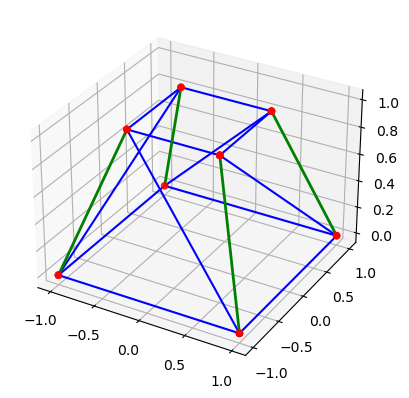

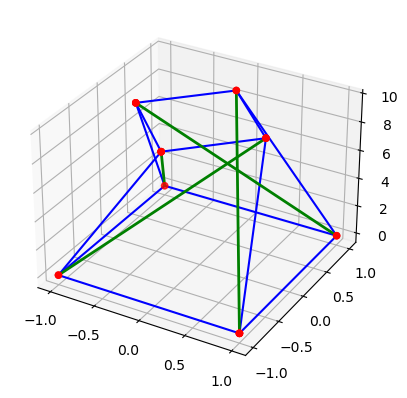

In [862]:
fixed_points = [0,1,2,3]
mg, pg, k, c = 0, 0, 0.1, 1
mu = 0

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
plot_bar_net(X, B, ax0)
X_BFGS = BFGS(E_constraint, gradient_E_constrained, np.copy(X), A,B,L, fixed_points, mg, pg, k, c, mu)
print(X_BFGS)
plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X_BFGS, A, ax0)
plot_bar_net(X_BFGS, B, ax0)

[[ 1.  -1.  -1.   1.   0.5 -0.5 -0.5  0.5]
 [ 1.   1.  -1.  -1.   0.5  0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   1.   1.   1.   1. ]]
number of BFGS steps = 30, number of step size optimization = 153, norm of gradient = 7.729115311094486e-14, Energy = 0.06608206267369403
[[ 1.      -1.      -1.       1.      -0.69011  0.17104  0.69011 -0.17104]
 [ 1.       1.      -1.      -1.      -0.17104 -0.69011  0.17104  0.69011]
 [ 0.       0.       0.       0.       9.39098  9.39098  9.39098  9.39098]]
-0.006000000000144515


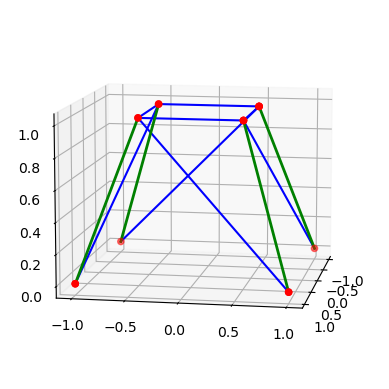

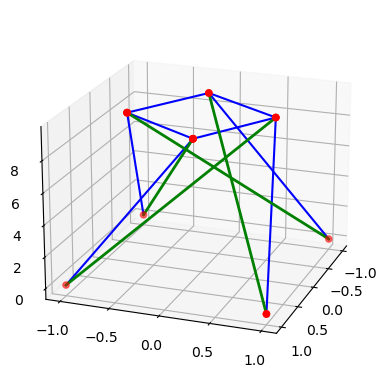

In [863]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
B = np.zeros((N,N))
a = 1
b = 1/2
c = 1
X[:,0] = [a,a,0]
X[:,1] = [-a,a,0]
X[:,2] = [-a,-a,0]
X[:,3] = [a,-a,0]

X[:,4] = [b,b,c]
X[:,5] = [-b,b,c]
X[:,6] = [-b,-b,c]
X[:,7] = [b,-b,c]  
#X[:,4:] = np.random.randint(-10, 10, size = (np.shape(X[:,4:])))

print(X)

cable_edges = np.array([[1,4], [2,5], [3,6], [0,7], [4,5], [5,6], [6,7], [7,4]])
bar_edges = np.array([[0,4], [1,5], [2,6], [3,7]])
create_edge(A, cable_edges)
create_edge(B, bar_edges)
fixed_points = [0,1,2,3]


plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
plot_bar_net(X, B, ax0)
ax0.view_init(10,10)

L = 10*B + 8*A

edges = np.array([[4,5],[5,6],[6,7],[4,7]])
create_edge(L,edges, 1)


X_BFGS = BFGS(E, gradient_E, np.copy(X), A, B, L, fixed_points, 0.001, 1e-4, 0.1, 1, tol = 1e-12, strong_w=True)
np.set_printoptions(precision=5)
print(X_BFGS)
print(np.sum(gradient_E(X_BFGS, A, B, L, fixed_points, 0 , 0, 0.1, 1)))

plt.figure()
ax1 = plt.axes(projection = '3d')
plot_cable_net(X_BFGS, A, ax1)
plot_bar_net(X_BFGS, B, ax1)
ax1.view_init(20,20)

number of gradient descent steps = 47, number of step size optimization = 464, norm of gradient = 8.829716973115663e-09, Energy = 1.1666666666666665
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]
number of gradient descent steps = 47, number of step size optimization = 511, norm of gradient = 8.829716973115663e-09, Energy = 1.1666666666666665
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]
number of gradient descent steps = 65, number of step size optimization = 1709, norm of gradient = 5.82316333896201e-09, Energy = 1.1666666666666663
[[ 5.  -5.  -5.   5.   2.  -2.  -2.   2. ]
 [ 5.   5.  -5.  -5.   2.   2.  -2.  -2. ]
 [ 0.   0.   0.   0.  -1.5 -1.5 -1.5 -1.5]]
number of BFGS steps = 47, number of step size optimization = 759, norm of gradient = 6.860927716439136e-14, Energy = 1.1666666666666665
[[ 5.  -5.  -5.   5.   2. 

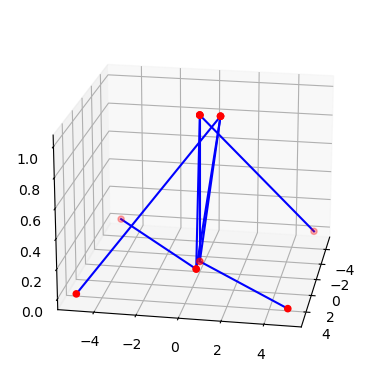

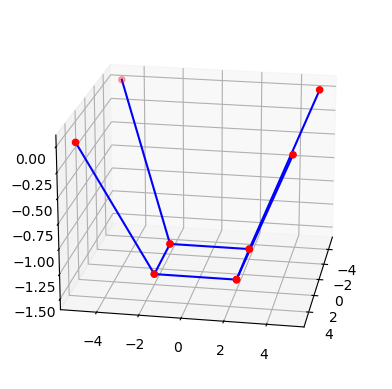

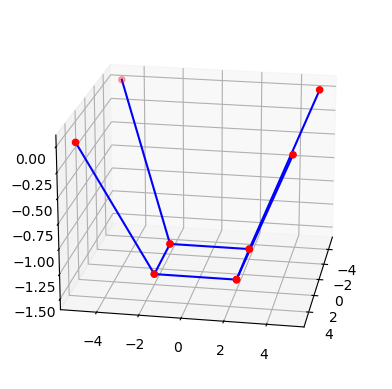

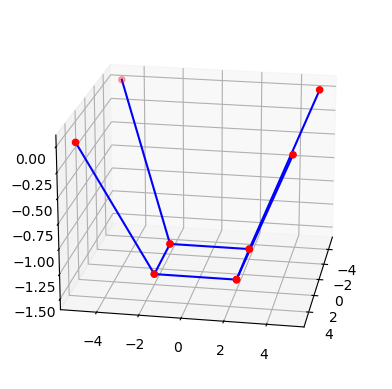

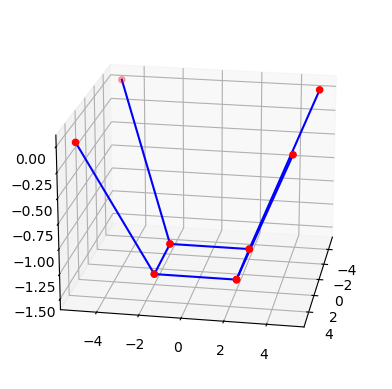

In [864]:
N = 8
X = np.zeros((3,N))
A = np.zeros((N,N))
X[:,0] = [5,5,0]
X[:,1] = [-5,5,0]
X[:,2] = [-5,-5,0]
X[:,3] = [5,-5,0]
X[:,4:] = np.random.randint(2, size = np.shape(X[:,4:]))

mg = 1/6
pg = 0
k = 3 
c = 0



edges = np.array([[1,5], [5,6], [4,5], [2,6], [6,7], [3,7], [4,7], [0,4]])
create_edge(A, edges, 1)
B = np.zeros_like(A)
L = 3*np.ones_like(A)
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
ax0.view_init(20,10)

plt.figure()
ax1 = plt.axes(projection = '3d')
X_const_step = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg, pg, k, c, tol = 1e-8, armijo = True)
plot_cable_net(X_const_step, A, ax1)
ax1.view_init(20,10)
print(X_const_step)

plt.figure()
ax2 = plt.axes(projection = '3d')
X_weak_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg, pg, k, c, tol = 1e-8, weak_w = True)
plot_cable_net(X_weak_wolfe, A, ax2)
ax2.view_init(20,10)
print(X_weak_wolfe)

plt.figure()
ax3 = plt.axes(projection = '3d')
X_strong_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg, pg, k, c, tol = 1e-8, strong_w = True)
plot_cable_net(X_strong_wolfe, A, ax3)
ax3.view_init(20,10)
print(X_strong_wolfe)


plt.figure()
ax4 = plt.axes(projection = '3d')
X_BFGS = BFGS(E,gradient_E, np.copy(X), A, B, L, fixed_points, mg , pg, k, c , tol = 1e-13, strong_w= True)
plot_cable_net(X_BFGS, A, ax4)
ax4.view_init(20,10)
print(X_BFGS)

print(gradient_E(X_BFGS, A, B, L, fixed_points, mg = 1/6, pg = 0, k = 3, c = 0))

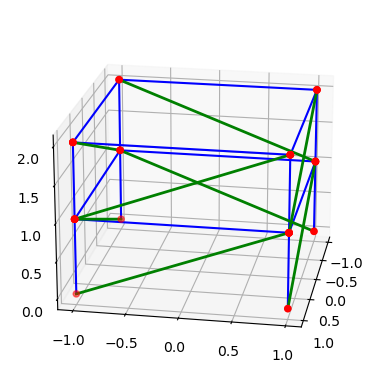

In [865]:
N = 12
X = np.zeros((3,N))
A = np.zeros((N,N))
B = np.zeros((N,N))
a = 1
b = 1
c = 1
X[:,0] = [a,a,0]
X[:,1] = [-a,a,0]
X[:,2] = [-a,-a,0]
X[:,3] = [a,-a,0]

X[:,4] = [b,b,1]
X[:,5] = [-b,b,1]
X[:,6] = [-b,-b,1]
X[:,7] = [b,-b, 1]

X[:,8] = [c,c,2]
X[:,9] = [-c,c,2]
X[:,10] = [-c,-c,2]
X[:,11] = [c,-c, 2]

#X[:,12] = [0,0,-10]
cable_edges = np.array([[1,5], [2,6], [3,7],[0,4], [4,5], [5,6], [6,7], [4,7], [4,8], [5,9], [6,10], [7,11], [4,8], [8,9],[9,10],[10,11],[11,8]])
bar_edges = np.array([[0,5], [1,6], [2,7], [3,4], [4, 9], [5,10], [6,11], [7,8]])
create_edge(A, cable_edges)
create_edge(B, bar_edges)
L = 2*B + 1*A
fixed_points = [0,1,2,3]

plt.figure()
ax0 = plt.axes(projection = '3d')
plot_cable_net(X, A, ax0)
plot_bar_net(X, B, ax0)
ax0.view_init(20,10)


number of BFGS steps = 22, number of step size optimization = 28, norm of gradient = 7.030058198971899e-11, Energy = 4.968949060142984e-22
[[ 1.      -1.      -1.       1.       0.68291 -0.71458 -0.68291  0.71458
   0.34728 -0.75715 -0.34728  0.75715]
 [ 1.       1.      -1.      -1.       0.71458  0.68291 -0.71458 -0.68291
   0.75715  0.34728 -0.75715 -0.34728]
 [ 0.       0.       0.       0.       0.97963  0.97963  0.97963  0.97963
   2.31804  2.31804  2.31804  2.31804]]


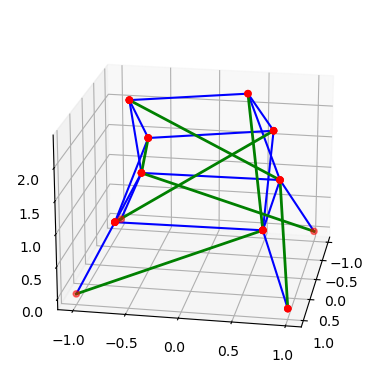

In [866]:
plt.figure()
ax1 = plt.axes(projection = '3d')
mg = 0;pg = 0; k = 0.1;c = 10

L = 1.4*A + 2*B
X_BFGS = BFGS(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg , pg , k , c, tol = 1e-10)
plot_cable_net(X_BFGS,A, ax1)
plot_bar_net(X_BFGS, B, ax1)
ax1.view_init(20,10)
print(X_BFGS)

number of gradient descent steps = 325, number of step size optimization = 2559, norm of gradient = 5.005468020064274e-09, Energy = 2.3683038078219382e-18


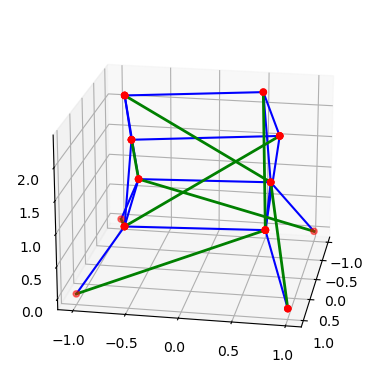

In [867]:
plt.figure()
ax2 = plt.axes(projection = '3d')
X_armijo = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg , pg , k , c , tol = 1e-8, armijo = True)
plot_cable_net(X_armijo,A, ax2)
plot_bar_net(X_armijo,B, ax2)
ax2.view_init(20,10)

number of gradient descent steps = 1000, number of step size optimization = 16224, norm of gradient = 3.563865037878915e-07, Energy = 2.659360776297078e-13


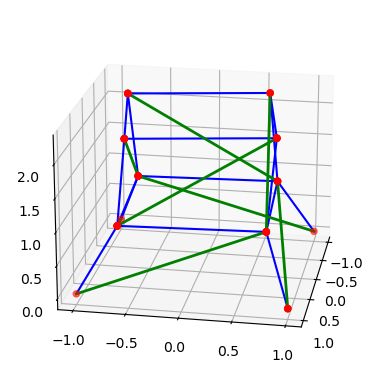

In [868]:
plt.figure()
ax4 = plt.axes(projection = '3d')
X_strong_wolfe = gradient_descent(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg , pg , k , c , tol = 1e-8, strong_w= True)
plot_cable_net(X_strong_wolfe, A, ax4)
plot_bar_net(X_strong_wolfe, B, ax4)
ax4.view_init(20,10)

number of BFGS steps = 22, number of step size optimization = 28, norm of gradient = 7.030058198971899e-11, Energy = 4.968949060142984e-22


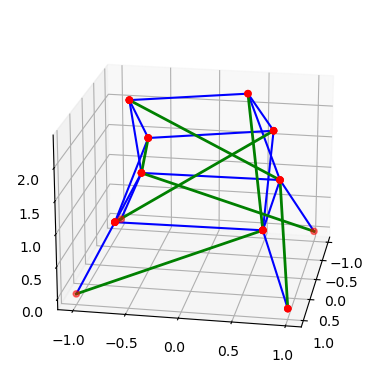

In [869]:
plt.figure()
ax4 = plt.axes(projection = '3d')
X_BFGS = BFGS(E, gradient_E, np.copy(X), A, B, L, fixed_points, mg , pg , k , c , tol = 1e-10, strong_w = True)
plot_cable_net(X_BFGS, A, ax4)
plot_bar_net(X_BFGS, B, ax4)
ax4.view_init(20,10)